In [ ]:
#!pip install --upgrade pip
#!pip install --upgrade setuptools
#!pip install GEOS

#!pip install GeobricksProj4ToEPSG
#!conda install -c conda-forge cartopy --yes
#!pip install geopandas
#print('ok')

In [6]:
import os
import pandas
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker
from IPython.display import display, HTML
import geopandas as gpd
#from shapely.geometry import Polygon
#from shapely.ops import cascaded_union, unary_union#, union
import time
import io
#import rtree

os.chdir('/home/idies/workspace/Temporary/raddick/cra_scratch/')
print(os.getcwd())
outdir = '/home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act/'
print(outdir)

/home/idies/workspace/Temporary/raddick/cra_scratch
/home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act/


# Lending by instituion and year

In [2]:
baltimore_originators_df = pandas.read_csv('loans_processed.csv', encoding='utf-8', index_col='rownumber')
#baltimore_df.sample(3).T

print('{0:,.0f} loans nationwide, of all types.'.format(len(baltimore_originators_df)))
baltimore_originators_df = baltimore_originators_df[
    (baltimore_originators_df['state'] == 24) &    (baltimore_originators_df['county'] == 510) &
    (baltimore_originators_df['loan_type'] == 4) &
    (baltimore_originators_df['action_taken_type'] == 1)
]
print('{0:,.0f} small business loans originated to Baltimore.'.format(len(baltimore_originators_df)))

baltimore_originators_df_bk = baltimore_originators_df

#baltimore_originators_df.sample(3).T
print('\nDONE!')

/home/idies/miniconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:518: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


11,243,729 loans nationwide, of all types.
12,733 small business loans originated to Baltimore.

DONE!


In [3]:
print('Reading from backup...')
baltimore_originators_df = baltimore_originators_df_bk

print('Totaling loan numbers and amounts...')
baltimore_originators_df = baltimore_originators_df.assign(nLoansTotal=baltimore_originators_df['nLoans1']+baltimore_originators_df['nLoans100k']+baltimore_originators_df['nLoans250k'])
baltimore_originators_df = baltimore_originators_df.assign(amtLoansTotal=baltimore_originators_df['amtLoans1']+baltimore_originators_df['amtLoans100k']+baltimore_originators_df['amtLoans250k'])
baltimore_originators_df = baltimore_originators_df.assign(amtLoansTotal_adjusted=baltimore_originators_df['amtLoans1_adjusted']+baltimore_originators_df['amtLoans100k_adjusted']+baltimore_originators_df['amtLoans250k_adjusted'])

print('Converting full level system to low/moderate/medium/upper...')
baltimore_originators_df = baltimore_originators_df.assign(cra_level = '')
baltimore_originators_df.loc[(baltimore_originators_df['income_group_total'].apply(lambda x: (x >= 1) & (x <=5))), 'cra_level'] = 'low'
baltimore_originators_df.loc[(baltimore_originators_df['income_group_total'].apply(lambda x: (x >= 6) & (x <=8))), 'cra_level'] = 'moderate'
baltimore_originators_df.loc[(baltimore_originators_df['income_group_total'].apply(lambda x: (x >= 9) & (x <=12))), 'cra_level'] = 'middle'
baltimore_originators_df.loc[(baltimore_originators_df['income_group_total'].apply(lambda x: (x == 13))), 'cra_level'] = 'upper'
baltimore_originators_df.loc[(baltimore_originators_df['income_group_total'].apply(lambda x: (x >= 14) & (x <=15))), 'cra_level'] = 'unknown'

#baltimore_originators_df.sample(3).T

baltimore_originators_df.groupby('cra_level').size().reindex(['low', 'moderate', 'middle', 'upper', 'unknown'])

Reading from backup...
Totaling loan numbers and amounts...
Converting full level system to low/moderate/medium/upper...


cra_level
low         4245
moderate    2547
middle      3394
upper        849
unknown     1698
dtype: int64

In [7]:
inst_year_df = baltimore_originators_df.groupby(['institution_name', 'activity_year'])['amtLoansTotal'].sum().unstack(1)#.sort_values)

sortorder = baltimore_originators_df[(baltimore_originators_df['institution_name'] != 'Unknown') & (baltimore_originators_df['activity_year'] == 2016)].groupby('institution_name', as_index=False)['amtLoansTotal'].sum().sort_values(by='amtLoansTotal', ascending=False)['institution_name'].values.tolist()
sortindex = pandas.Index(sortorder)
inst_year_df = inst_year_df.reindex(sortindex)

htmlstring = '<h1>Lending in Baltimore City by institution, 2004-2016</h1>'
htmlstring += '<table>'
htmlstring += '<tr>'
htmlstring += '<th>Institution</th>'
for i in range(2004, 2017):
    htmlstring += '<th>'+str(i)+'</th>'
htmlstring += '</tr>'
for idx, thisrow in inst_year_df.iterrows():
    htmlstring += '<tr>'
    htmlstring += '<td>{0:}</td>'.format(idx)
    for i in range(0, len(thisrow)):
#    for i in range(5, 13):
        if ('<td>${0:,.0f}</td>'.format(thisrow.iloc[i]) == '<td>$nan</td>'):
            htmlstring += '<td></td>'
        else:
            htmlstring += '<td>${0:,.0f}</td>'.format(thisrow.iloc[i])
    htmlstring += '</tr>'
htmlstring += '</table>'

inst_year_df.to_csv(outdir+'institutions_by_year.csv', encoding='utf-8')
print('ok')

display(HTML(htmlstring))

ok


Institution,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
M&T BANK (NY),"$54,767,000","$45,697,000","$50,646,000","$54,189,000","$36,108,000","$19,674,000","$21,441,000","$26,788,000","$19,644,000","$26,966,000","$43,679,000","$42,369,000","$55,036,000"
PNC BANK N.A. (PA),"$250,000","$2,904,000","$2,965,000","$55,318,000","$54,759,000","$49,816,000","$47,138,000","$46,199,000","$41,522,000","$50,729,000","$40,007,000","$41,005,000","$43,213,000"
"American Express, FSB (UT)",,,,,,,,"$10,723,000","$14,394,000","$14,052,000","$15,116,000","$19,737,000","$24,486,000"
"WELLS FARGO BANK, N.A. (CA)","$46,441,000","$48,729,000","$61,808,000","$59,267,000","$51,381,000","$35,061,000","$21,358,000","$27,560,000","$24,844,000","$28,119,000","$25,427,000","$27,419,000","$24,247,000"
"Bank of America, N.A. (CA)","$41,577,000","$49,903,000","$38,894,000","$34,350,000","$31,610,000","$24,802,000","$21,722,000","$19,041,000","$16,279,000","$20,315,000","$21,536,000","$21,701,000","$21,986,000"
1ST MARINER BANK (MD),"$13,382,000","$14,090,000","$12,374,000","$16,065,000","$12,860,000","$14,272,000","$13,336,000","$11,241,000","$14,037,000","$9,213,000","$11,187,000","$14,004,000","$11,657,000"
Barrington Bank and Trust (IL),,,,,,,,,,,,,"$11,276,000"
Sandy Spring Bank (MD),"$1,896,000","$4,526,000","$2,580,000","$3,156,000","$2,892,000","$3,325,000","$3,390,000","$4,581,000","$5,431,000","$7,773,000","$13,180,000","$13,384,000","$11,146,000"
"SUNTRUST BANKS, INC (GA)","$19,952,000","$17,682,000","$25,438,000","$23,254,000","$24,243,000","$17,863,000","$18,012,000","$13,837,000","$11,817,000","$9,499,000","$17,556,000","$13,390,000","$10,016,000"
FIRST NATIONAL BANK OF PA (PA),,,,,,,,,"$1,352,000","$596,000","$10,037,000","$8,293,000","$8,468,000"


In [5]:
inst_year_df = baltimore_originators_df.groupby(['institution_name', 'activity_year'])['amtLoansTotal_adjusted'].sum().unstack(1)#.sort_values)

sortorder = baltimore_originators_df[(baltimore_originators_df['institution_name'] != 'Unknown') & (baltimore_originators_df['activity_year'] == 2016)].groupby('institution_name', as_index=False)['amtLoansTotal'].sum().sort_values(by='amtLoansTotal', ascending=False)['institution_name'].values.tolist()
sortindex = pandas.Index(sortorder)
inst_year_df = inst_year_df.reindex(sortindex)

htmlstring = '<h1>Lending in Baltimore City by institution, 2004-2016 (inflation-adjusted to 2016 dollars)</h1>'
htmlstring += '<table>'
htmlstring += '<tr>'
htmlstring += '<th>Institution</th>'
for i in range(2004, 2017):
    htmlstring += '<th>'+str(i)+'</th>'
htmlstring += '</tr>'
for idx, thisrow in inst_year_df.iterrows():
    htmlstring += '<tr>'
    htmlstring += '<td>{0:}</td>'.format(idx)
    for i in range(0, len(thisrow)):
        if ('<td>${0:,.0f}</td>'.format(thisrow.iloc[i]) == '<td>$nan</td>'):
            htmlstring += '<td></td>'
        else:
            htmlstring += '<td>${0:,.0f}</td>'.format(thisrow.iloc[i])
    htmlstring += '</tr>'
htmlstring += '</table>'


inst_year_df.to_csv(outdir+'institutions_by_year_adjusted.csv', encoding='utf-8')
print('OK')

display(HTML(htmlstring))

OK


Institution,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
M&T BANK (NY),"$69,499,323","$56,070,219","$60,572,616","$62,263,161","$41,451,984","$21,995,532","$23,627,982","$28,663,160","$20,665,488","$27,936,776","$44,902,012","$43,258,749","$55,036,000"
PNC BANK N.A. (PA),"$317,250","$3,563,208","$3,546,140","$63,560,382","$62,863,332","$55,694,288","$51,946,076","$49,432,930","$43,681,144","$52,555,244","$41,127,196","$41,866,105","$43,213,000"
"American Express, FSB (UT)",,,,,,,,"$11,473,610","$15,142,488","$14,557,872","$15,539,248","$20,151,477","$24,486,000"
"WELLS FARGO BANK, N.A. (CA)","$58,933,629","$59,790,483","$73,922,368","$68,097,783","$58,985,388","$39,198,198","$23,536,516","$29,489,200","$26,135,888","$29,131,284","$26,138,956","$27,994,799","$24,247,000"
"Bank of America, N.A. (CA)","$52,761,213","$61,230,981","$46,517,224","$39,468,150","$36,288,280","$27,728,636","$23,937,644","$20,373,870","$17,125,508","$21,046,340","$22,139,008","$22,156,721","$21,986,000"
1ST MARINER BANK (MD),"$16,981,758","$17,288,430","$14,799,304","$18,458,685","$14,763,280","$15,956,096","$14,696,272","$12,027,870","$14,766,924","$9,544,668","$11,500,236","$14,298,084","$11,657,000"
Barrington Bank and Trust (IL),,,,,,,,,,,,,"$11,276,000"
Sandy Spring Bank (MD),"$2,406,024","$5,553,402","$3,085,680","$3,626,244","$3,320,016","$3,717,350","$3,735,780","$4,901,670","$5,713,412","$8,052,828","$13,549,040","$13,665,064","$11,146,000"
"SUNTRUST BANKS, INC (GA)","$25,319,088","$21,695,814","$30,423,848","$26,718,846","$27,830,964","$19,970,834","$19,849,224","$14,805,590","$12,431,484","$9,840,964","$18,047,568","$13,671,190","$10,016,000"
FIRST NATIONAL BANK OF PA (PA),,,,,,,,,"$1,422,304","$617,456","$10,318,036","$8,467,153","$8,468,000"


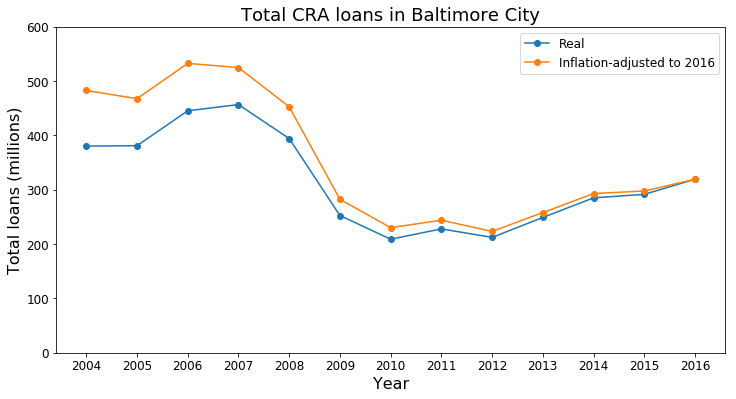

figure saved


<Figure size 432x288 with 0 Axes>

In [10]:
def ymillions(x,pos):
    return '{0:.0f}'.format(x/1000000)

year_df = baltimore_originators_df.groupby(['activity_year'])['amtLoansTotal'].sum()#.unstack(1)
year_adj_df = baltimore_originators_df.groupby(['activity_year'])['amtLoansTotal_adjusted'].sum()#.unstack(1)

#sortorder = baltimore_originators_df[(baltimore_originators_df['institution_name'] != 'Unknown') & (baltimore_originators_df['activity_year'] == 2016)].groupby('institution_name', as_index=False)['amtLoansTotal'].sum().sort_values(by='amtLoansTotal', ascending=False)['institution_name'].values.tolist()
#sortindex = pandas.Index(sortorder)
#inst_year_df = inst_year_df.reindex(sortindex)

fig, ax1 = plt.subplots(figsize=(12,6))

ax1.plot(year_df.index, year_df.values, marker='o', label='Real')
ax1.plot(year_adj_df.index, year_adj_df.values, marker='o', label='Inflation-adjusted to 2016')

ax1.xaxis.set_major_locator(ticker.FixedLocator([2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]))

ax1.set_ylim((0,600000000))
ax1.yaxis.set_major_locator(ticker.AutoLocator())
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(ymillions))

plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Total loans (millions)', fontsize=16)
plt.title('Total CRA loans in Baltimore City', fontsize=18)
plt.legend(fontsize=12)
plt.show()
plt.savefig(outdir+'total_loans_by_year.svg', format='svg')
print('figure saved')